<a href="https://colab.research.google.com/github/Afrah333333/deep-learning-projects/blob/main/Experiment_tracking_and_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EXPERIMENTATION
So our goals are:

Performance - A model that performs at 95%+ accuracy.

Speed - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

Experimenting will allow us to find the ideal model that performs fast and well for deploying

Setup modules

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Function to set seed which is used to ensure that results are reproducible

In [ ]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

Getting custom data of taco, hotdog and icecream

In [ ]:
import os
import requests
import zipfile
from pathlib import Path

data_path = Path('./Downloads')
image_path = data_path / 'taco_hotdog_icecream'

#if directory does not exist make one

if image_path.is_dir():
    print(f'{image_path} directory exists')
else:
    print(f'{image_path} does not exist')
    image_path.mkdir(parents=True, exist_ok=True)

#download the data
with open(data_path / 'taco_hotdog_icecream_20_percent.zip', 'wb') as f:
    url = "https://github.com/Afrah333333/deep-learning/raw/master/Downloads/taco_hotdog_icecream_20_percent.zip"
    request = requests.get(url)
    print("Downloading taco_hotdog_icecream data...")
    f.write(request.content)

try:
    with zipfile.ZipFile(data_path / "taco_hotdog_icecream_20_percent.zip", "r") as zip_ref:
        print("Unzipping taco, hotdog, icecream...")
        zip_ref.extractall(image_path)
except zipfile.BadZipFile:
    print("Error: Invalid or corrupted zip file.")
except Exception as e:
    print(f"An error occurred: {e}")





Downloads/taco_hotdog_icecream does not exist
Unzipping taco, hotdog, icecream...


In [ ]:
#Data Directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('Downloads/taco_hotdog_icecream/train'),
 PosixPath('Downloads/taco_hotdog_icecream/test'))

Creating an EffNetB2 feature extractor

In [ ]:
# 1. Setup pretrained EffNetB2 weights

from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
#effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 79.4MB/s]


In [ ]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

Creating a function to make an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
# Creating DataLoaders for EffNetB2

#setup datasets
# Use ImageFolder to create dataset(s)
from torchvision import datasets
effnetb2_train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=effnetb2_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

effnetb2_test_data = datasets.ImageFolder(root=test_dir,
                                 transform=effnetb2_transforms)

class_names = effnetb2_train_data.classes

print(f"Train data:\n{effnetb2_train_data}\nTest data:\n{effnetb2_test_data}")
print('The class naes are:',class_names)

# Setup DataLoaders
from torch.utils.data import DataLoader
effnetb2_train_dataloader = DataLoader(dataset=effnetb2_train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

effnetb2_test_dataloader = DataLoader(dataset=effnetb2_test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

effnetb2_train_dataloader, effnetb2_test_dataloader

Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: Downloads/taco_hotdog_icecream/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: Downloads/taco_hotdog_icecream/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
The class naes are: ['hot_dog', 'ice_cream', 'tacos']


(<torch.utils.data.dataloader.DataLoader at 0x78c00edc4b80>,
 <torch.utils.data.dataloader.DataLoader at 0x78c00edc6140>)

In [ ]:
#setup train function
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results




In [ ]:
#training effnetb2 feature extractor

# Setup optimizer
effnetb2_optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
effnetb2_loss_fn = torch.nn.CrossEntropyLoss()

# Set random seeds
set_seeds()



# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
effnetb2_results = train(model=effnetb2.to(device),
                       train_dataloader=effnetb2_train_dataloader,
                       test_dataloader=effnetb2_test_dataloader,
                       optimizer=effnetb2_optimizer,
                       loss_fn=effnetb2_loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9997 | train_acc: 0.5563 | test_loss: 0.7670 | test_acc: 0.8335
Epoch: 2 | train_loss: 0.7422 | train_acc: 0.8354 | test_loss: 0.6101 | test_acc: 0.9040
Epoch: 3 | train_loss: 0.6027 | train_acc: 0.8729 | test_loss: 0.5383 | test_acc: 0.9131
Epoch: 4 | train_loss: 0.5135 | train_acc: 0.8542 | test_loss: 0.4696 | test_acc: 0.9006
Epoch: 5 | train_loss: 0.4631 | train_acc: 0.8812 | test_loss: 0.4278 | test_acc: 0.9102
Epoch: 6 | train_loss: 0.4431 | train_acc: 0.8771 | test_loss: 0.3806 | test_acc: 0.9222
Epoch: 7 | train_loss: 0.4362 | train_acc: 0.8438 | test_loss: 0.3561 | test_acc: 0.9068
Epoch: 8 | train_loss: 0.4221 | train_acc: 0.8729 | test_loss: 0.3510 | test_acc: 0.9040
Epoch: 9 | train_loss: 0.3631 | train_acc: 0.9104 | test_loss: 0.3213 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8792 | test_loss: 0.3160 | test_acc: 0.9131
Total training time: 74.082 seconds


In [ ]:
#plot curves
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()



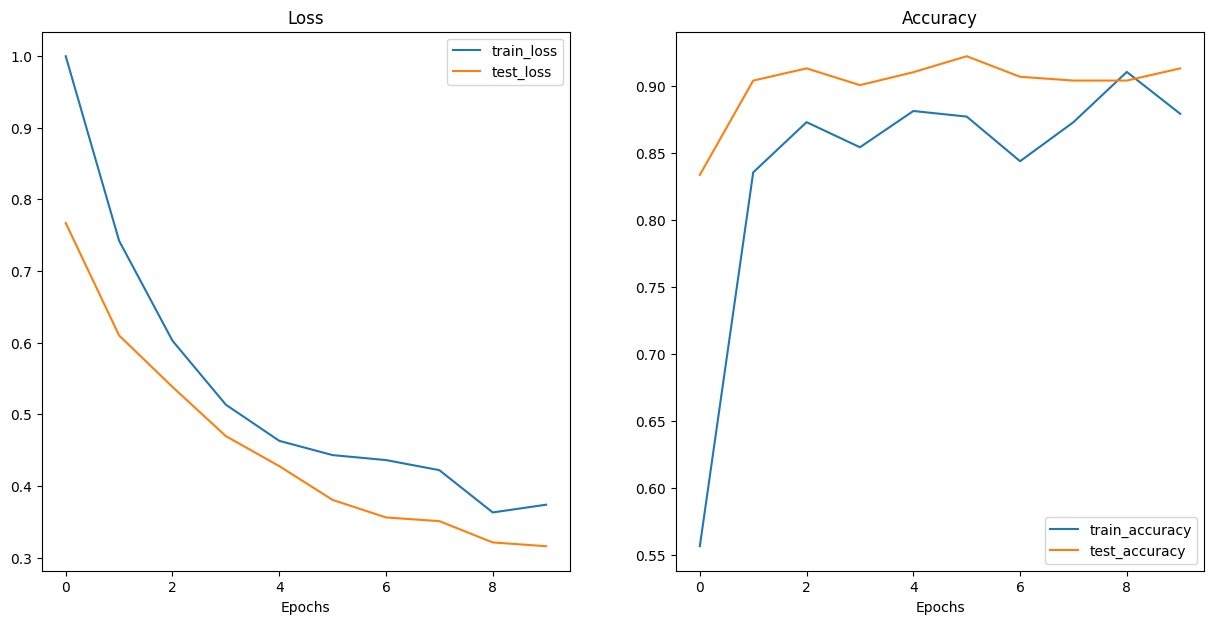

In [ ]:
#visualizing loss curve

plot_loss_curves(effnetb2_results)

In [ ]:
#save model function
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
#Saving EffNetB2 feature extractor

# Save the model
save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth


Checking the size of EffNetB2 feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
#Now let's put everything in a dictionary so we can make comparisons later on.

# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.3159707188606262,
 'test_acc': 0.9130681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

Creating a ViT feature extractor

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 98.1MB/s]


In [ ]:
# Creating DataLoaders for ViT

#setup datasets
# Use ImageFolder to create dataset(s)
from torchvision import datasets
vit_train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=vit_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

vit_test_data = datasets.ImageFolder(root=test_dir,
                                 transform=vit_transforms)

print(f"Train data:\n{vit_train_data}\nTest data:\n{vit_test_data}")

# Setup DataLoaders
from torch.utils.data import DataLoader
vit_train_dataloader = DataLoader(dataset=vit_train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

vit_test_dataloader = DataLoader(dataset=vit_test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

vit_train_dataloader, vit_test_dataloader

Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: Downloads/taco_hotdog_icecream/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: Downloads/taco_hotdog_icecream/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


(<torch.utils.data.dataloader.DataLoader at 0x78c006d393f0>,
 <torch.utils.data.dataloader.DataLoader at 0x78c006d3b190>)

In [ ]:
#training vit feature extractor

# Setup optimizer
vit_optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
vit_loss_fn = torch.nn.CrossEntropyLoss()

# Set random seeds
set_seeds()



# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
vit_results = train(model=vit.to(device),
                       train_dataloader=vit_train_dataloader,
                       test_dataloader=vit_test_dataloader,
                       optimizer=vit_optimizer,
                       loss_fn=vit_loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5403 | train_acc: 0.8500 | test_loss: 0.1655 | test_acc: 0.9875
Epoch: 2 | train_loss: 0.2133 | train_acc: 0.9292 | test_loss: 0.0812 | test_acc: 0.9812
Epoch: 3 | train_loss: 0.1019 | train_acc: 0.9729 | test_loss: 0.0777 | test_acc: 0.9659
Epoch: 4 | train_loss: 0.0842 | train_acc: 0.9792 | test_loss: 0.0649 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.0693 | train_acc: 0.9875 | test_loss: 0.0616 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.0616 | train_acc: 0.9917 | test_loss: 0.0584 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0517 | train_acc: 0.9917 | test_loss: 0.0568 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0467 | train_acc: 0.9917 | test_loss: 0.0553 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0402 | train_acc: 0.9917 | test_loss: 0.0535 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0407 | train_acc: 0.9938 | test_loss: 0.0535 | test_acc: 0.9875
Total training time: 82.328 seconds


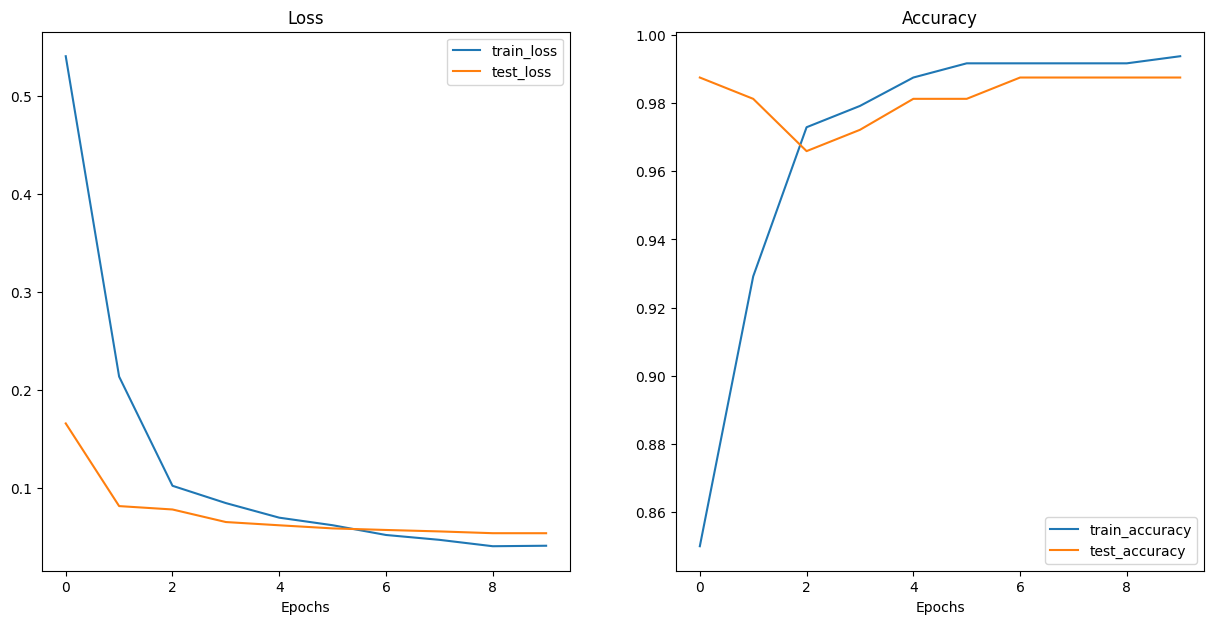

In [ ]:
#visualizing loss curve

plot_loss_curves(vit_results)

In [ ]:
# Save the model

save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_taco_hotdog_icecream_20_percent.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_taco_hotdog_icecream_20_percent.pth


Checking the size of ViT feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_taco_hotdog_icecream_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.05346621349453926,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

Making predictions with our trained models and timing them

In [ ]:
#we'll use Python's pathlib.Path("target_dir").glob("*/*.jpg")) to find all of the filepaths in a target directory with the extension .jpg (all of our test images).

from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[110:115]

[INFO] Finding all filepaths ending with '.jpg' in directory: Downloads/taco_hotdog_icecream/test


[PosixPath('Downloads/taco_hotdog_icecream/test/hot_dog/591179.jpg'),
 PosixPath('Downloads/taco_hotdog_icecream/test/hot_dog/108287.jpg'),
 PosixPath('Downloads/taco_hotdog_icecream/test/hot_dog/3902792.jpg'),
 PosixPath('Downloads/taco_hotdog_icecream/test/hot_dog/718939.jpg'),
 PosixPath('Downloads/taco_hotdog_icecream/test/hot_dog/471340.jpg')]

Creating a function to make predictions across the test dataset

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

         # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

Making and timing predictions with EffNetB2

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 3 prediction dictionaries
effnetb2_test_pred_dicts[:3]

[{'image_path': PosixPath('Downloads/taco_hotdog_icecream/test/ice_cream/1442308.jpg'),
  'class_name': 'ice_cream',
  'pred_prob': 0.7346,
  'pred_class': 'ice_cream',
  'time_for_pred': 0.3226,
  'correct': True},
 {'image_path': PosixPath('Downloads/taco_hotdog_icecream/test/ice_cream/198102.jpg'),
  'class_name': 'ice_cream',
  'pred_prob': 0.7525,
  'pred_class': 'ice_cream',
  'time_for_pred': 0.1177,
  'correct': True},
 {'image_path': PosixPath('Downloads/taco_hotdog_icecream/test/ice_cream/3410886.jpg'),
  'class_name': 'ice_cream',
  'pred_prob': 0.9114,
  'pred_class': 'ice_cream',
  'time_for_pred': 0.1121,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.7346,ice_cream,0.3226,True
1,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.7525,ice_cream,0.1177,True
2,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.9114,ice_cream,0.1121,True
3,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.8385,ice_cream,0.1113,True
4,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.4811,hot_dog,0.1054,False


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     137
False     13
Name: correct, dtype: int64

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1157 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.3159707188606262,
 'test_acc': 0.9130681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1157}

Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:3]

[{'image_path': PosixPath('Downloads/taco_hotdog_icecream/test/ice_cream/1442308.jpg'),
  'class_name': 'ice_cream',
  'pred_prob': 0.978,
  'pred_class': 'ice_cream',
  'time_for_pred': 0.714,
  'correct': True},
 {'image_path': PosixPath('Downloads/taco_hotdog_icecream/test/ice_cream/198102.jpg'),
  'class_name': 'ice_cream',
  'pred_prob': 0.9993,
  'pred_class': 'ice_cream',
  'time_for_pred': 0.4088,
  'correct': True},
 {'image_path': PosixPath('Downloads/taco_hotdog_icecream/test/ice_cream/3410886.jpg'),
  'class_name': 'ice_cream',
  'pred_prob': 0.9986,
  'pred_class': 'ice_cream',
  'time_for_pred': 0.4076,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.9780,ice_cream,0.7140,True
1,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.9993,ice_cream,0.4088,True
2,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.9986,ice_cream,0.4076,True
3,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.9727,ice_cream,0.4151,True
4,Downloads/taco_hotdog_icecream/test/ice_cream/...,ice_cream,0.9224,ice_cream,0.4005,True


In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4344 seconds


In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05346621349453926,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.4344}

Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.315971,91.31,7705221,29,0.1157,EffNetB2
1,0.053466,98.75,85800963,327,0.4344,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.169213,1.081481,11.135432,11.275862,3.754538


Visualizing the speed vs. performance tradeoff

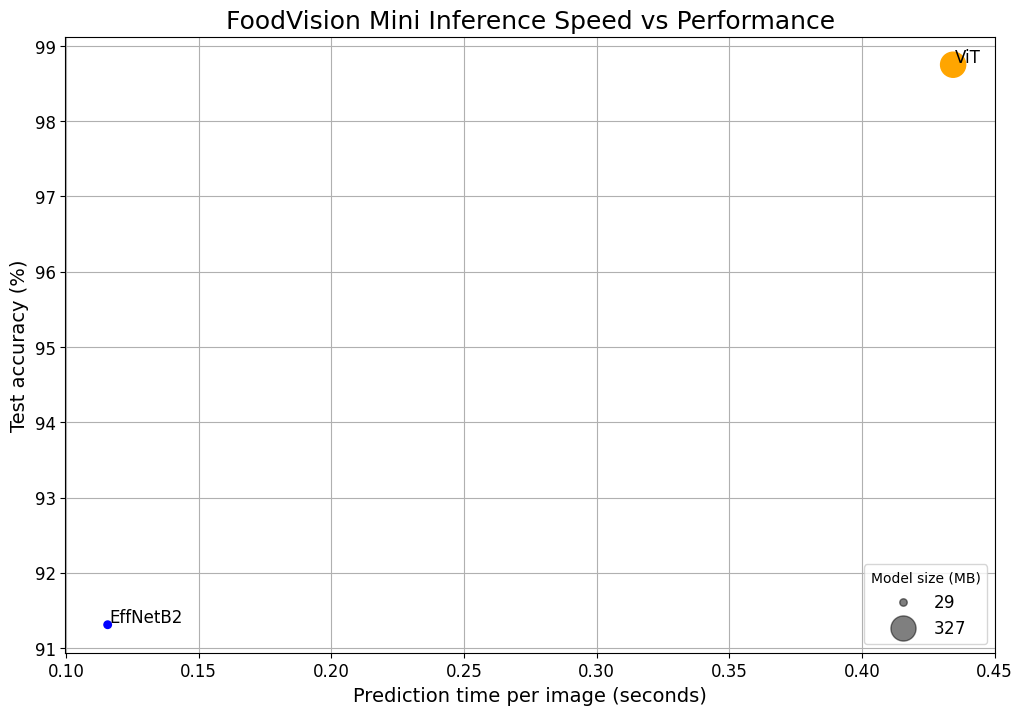

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure

plt.savefig("Downloads/speed-vs-performance.jpg")

# Show the figure
plt.show()

#DEPLOYING OUR MODEL

In [ ]:
#We'll start by importing Gradio with the common alias gr and if it's not present, we'll install it.

# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into accou

In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
#setup predict function
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
#predictions on random images
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: Downloads/taco_hotdog_icecream/test/ice_cream/3885955.jpg

Prediction label and probability dictionary: 
{'hot_dog': 0.1444471925497055, 'ice_cream': 0.6922966241836548, 'tacos': 0.1632562279701233}
Prediction time: 0.10709 seconds


In [ ]:
#let's create a list of lists containing random filepaths to our test images.
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['Downloads/taco_hotdog_icecream/test/ice_cream/1498499.jpg'],
 ['Downloads/taco_hotdog_icecream/test/ice_cream/1004744.jpg'],
 ['Downloads/taco_hotdog_icecream/test/tacos/3300773.jpg']]

In [ ]:
!pip install --upgrade gradio httpx


Building a Gradio interface

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Tiny Foods"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as taco, hotdog or icecream."


# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article='')

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bc66af38d954e1fa52.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Turning our Tiny Foods Gradio Demo into a deployable app


In [ ]:
#To begin, let's first create a demos/ directory to store all of our Tiny Foods app files.

#We can do with Python's pathlib.Path("path_to_dir") to establish the directory path and pathlib.Path("path_to_dir").mkdir() to create it.

import shutil
from pathlib import Path

# Create FoodVision mini demo path
Tiny_foods_demo_path = Path("demos/Tiny_foods/")

# Remove files that might already exist there and create new directory
if Tiny_foods_demo_path.exists():
    shutil.rmtree(Tiny_foods_demo_path)
    Tiny_foods_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    Tiny_foods_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/Tiny_foods/

In [ ]:
#Creating a folder of example images to use with our Tiny foods demo

import shutil
from pathlib import Path

# 1. Create an examples directory
Tiny_foods_examples_path = Tiny_foods_demo_path / "examples"
Tiny_foods_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
Tiny_foods_examples = [Path('/content/Downloads/taco_hotdog_icecream/test/ice_cream/1840963.jpg'),
                            Path('/content/Downloads/taco_hotdog_icecream/test/hot_dog/635715.jpg'),
                            Path('/content/Downloads/taco_hotdog_icecream/test/tacos/1320199.jpg')]

# 3. Copy the three random images to the examples directory
for example in Tiny_foods_examples:
    destination = Tiny_foods_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying /content/Downloads/taco_hotdog_icecream/test/ice_cream/1840963.jpg to demos/Tiny_foods/examples/1840963.jpg
[INFO] Copying /content/Downloads/taco_hotdog_icecream/test/hot_dog/635715.jpg to demos/Tiny_foods/examples/635715.jpg
[INFO] Copying /content/Downloads/taco_hotdog_icecream/test/tacos/1320199.jpg to demos/Tiny_foods/examples/1320199.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(Tiny_foods_examples_path)]
example_list

[['examples/1320199.jpg'], ['examples/1840963.jpg'], ['examples/635715.jpg']]

In [ ]:
#Moving our trained EffNetB2 model to our Tiny foods demo directory

import shutil

# Create a source path for our target model
effnetb2_tiny_foods_model_path = "models/pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth"

# Create a destination path for our target model
effnetb2_tiny_foods_model_destination = Tiny_foods_demo_path / effnetb2_tiny_foods_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_tiny_foods_model_path} to {effnetb2_tiny_foods_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_tiny_foods_model_path,
                dst=effnetb2_tiny_foods_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_tiny_foods_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_tiny_foods_model_destination}: {effnetb2_tiny_foods_model_destination.exists()}")


[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth to demos/Tiny_foods/pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth
[INFO] Model move complete.


In [ ]:
#Turning our EffNetB2 model into a Python script (model.py)
%%writefile demos/Tiny_foods/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/Tiny_foods/model.py


In [ ]:
#Turning our Tiny foods Gradio app into a Python script (app.py)
%%writefile demos/Tiny_foods/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["taco", "hotdog", "icecream"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Tiny foods"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as taco, hotdog or icecream."
article = ""

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/Tiny_foods/app.py


In [ ]:
#Creating a requirements file for FoodVision Mini (requirements.txt)
%%writefile demos/Tiny_foods/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/Tiny_foods/requirements.txt


Deploying our Tiny foods app to HuggingFace Spaces

In [ ]:
#Downloading our Tiny foods app files
!ls demos/Tiny_foods

app.py	  pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth
examples  requirements.txt
model.py


In [ ]:
# Change into and then zip the Tiny foods folder but exclude certain files
!cd demos/Tiny_foods && zip -r ../Tiny_foods.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/Tiny_foods.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 58%)
  adding: examples/ (stored 0%)
  adding: examples/1320199.jpg (deflated 1%)
  adding: examples/1840963.jpg (deflated 27%)
  adding: examples/635715.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: pretrained_effnetb2_feature_extractor_taco_hotdog_icecream_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed Tiny foods Gradio demo
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)